In [268]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


In [269]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")

In [289]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1
XX = pd.get_dummies(X)


In [235]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train = pd.get_dummies(X)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

rus = RandomUnderSampler(sampling_strategy=0.03)  # Proporzione è sempre 1:36, ho ipotizzato che il dataset su cui andremo a fare le nostre prediction sia delle stesse dimensioni di questo, 360k. Dovendo andare a prendere i top 10k clienti ho cercato di mantenere le stesse proporzioni
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


LightGBM : Tuning hyperparametri

In [201]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)
    missing_columns_train = set(XX.columns) - set(X_train.columns)
    for col in missing_columns_train:
        X_train[col] = 0

    missing_columns_test = set(XX.columns) - set(X_test.columns)
    for col in missing_columns_test:
        X_test[col] = 0

    X_train = X_train[XX.columns]
    X_test = X_test[XX.columns]
        
    rus = RandomUnderSampler(sampling_strategy=0.03)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)  
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)
    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 2**trial.suggest_int('max_depth', 5, 15)),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'random_state': 42,
        'force_col_wise': True,
        'verbosity': -1
    }
# CV : ogni fold è usato 1 volta per la validation e 9 per il training, in questo modo riduciamo la varianza al minimo
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)


sampler = optuna.samplers.TPESampler(seed=42)  

study = optuna.create_study(direction='maximize', sampler = sampler)

study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()


[I 2024-04-19 07:56:32,783] A new study created in memory with name: no-name-645b0b6e-7d6f-4ccc-87a7-55e2fdfc685f
[I 2024-04-19 07:56:51,955] Trial 0 finished with value: 0.9892131776403843 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 4912, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.9892131776403843.
[I 2024-04-19 07:57:05,945] Trial 1 finished with value: 0.9897727691314596 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 39, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.9897727691314596.
[I 2024-04-

KeyboardInterrupt: 

In [255]:
'''
Best Hyperparameters: {'n_estimators': 195, 'learning_rate': 0.0689356536665432, 'max_depth': 13, 'num_leaves': 1946, 'min_child_samples': 37, 'subsample': 0.8841796423370363, 'subsample_freq': 0, 'colsample_bytree': 0.783386192594209, 'reg_alpha': 0.7592044537020304, 'reg_lambda': 0.538402350448647, 'max_bin': 269}
Best ROC AUC Score: 0.9918504426589758
'''
best_params = {
    'n_estimators': 195,
    'learning_rate': 0.0689356536665432,
    'max_depth': 13,
    'num_leaves': 1946,
    'min_child_samples': 37,
    'subsample': 0.8841796423370363,
    'subsample_freq': 0,
    'colsample_bytree': 0.783386192594209,
    'reg_alpha': 0.7592044537020304,
    'reg_lambda': 0.538402350448647,
    'max_bin': 269,
    'random_state': 42,
    'force_col_wise': True,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_res, y_train_res)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [120]:
best_lgb_classifier

LGBMClassifier(colsample_bytree=0.6518355641936273, force_col_wise=True,
               learning_rate=0.045336423535558106, max_bin=280, max_depth=8,
               min_child_samples=50, n_estimators=264, num_leaves=72,
               random_state=42, reg_alpha=0.6759647727667966,
               reg_lambda=0.9300125049175274, subsample=0.9563930027208176,
               subsample_freq=1, verbosity=-1)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

#best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

       y_test  y_pred_proba
17390       1      0.998216
5648        1      0.997695
6512        1      0.996787
6664        1      0.995940
383         1      0.995591
...       ...           ...
32997       0      0.000144
39700       0      0.000144
28283       0      0.000144
40279       0      0.000144
54904       0      0.000144

[10000 rows x 2 columns]


In [286]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 373
Numero di 'SI: nel nostro test set 375


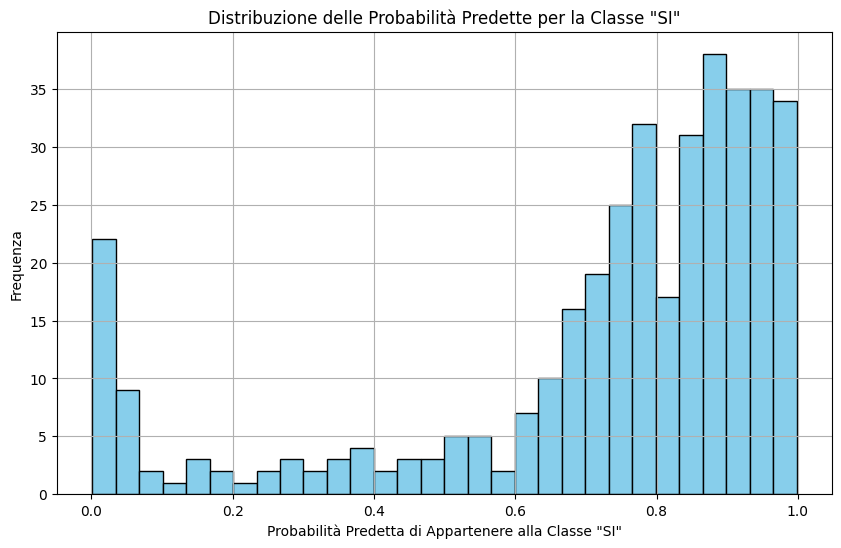

In [287]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

XGBoost: Tuning hyperparametri

In [121]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)
    missing_columns_train = set(XX.columns) - set(X_train.columns)
    for col in missing_columns_train:
        X_train[col] = 0

    missing_columns_test = set(XX.columns) - set(X_test.columns)
    for col in missing_columns_test:
        X_test[col] = 0

    X_train = X_train[XX.columns]
    X_test = X_test[XX.columns]
        
    rus = RandomUnderSampler(sampling_strategy=0.03)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)  
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)
    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train, eval_metric="auc")
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.5),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 

In [294]:
'''
Best Hyperparameters: {'sampling_strategy': 0.1251773261463979, 'n_estimators': 911, 'learning_rate': 0.05255473835317336, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6405856996548562, 'colsample_bytree': 0.9964394946899515, 'gamma': 1.2121534098151838, 'reg_alpha': 1.1808576291047457, 'reg_lambda': 2.7143652609430546}
Best ROC AUC Score: 0.9910838203489621
'''
xgb_params = {
    'n_estimators': 911,
    'learning_rate': 0.05255473835317336,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.6405856996548562,
    'colsample_bytree': 0.9964394946899515,
    'gamma': 1.2121534098151838,
    'reg_alpha': 1.1808576291047457,
    'reg_lambda': 2.7143652609430546,
    'random_state': 42  
}

best_xgb_classifier = xgb.XGBClassifier(**xgb_params)

best_xgb_classifier.fit(X_train, y_train)
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]

In [123]:
best_xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9964394946899515, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2121534098151838,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05255473835317336,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=911, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

#best_lgb_classifier.fit(X_train, y_train)
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': xgb_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

NotFittedError: need to call fit or load_model beforehand

In [300]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 392
Numero di 'SI: nel nostro test set 393


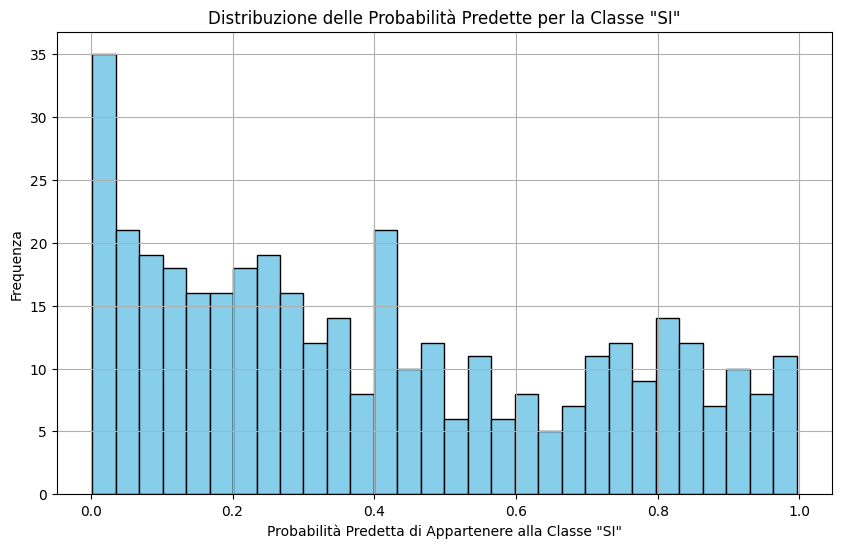

In [301]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

Catboost: Tuning hyperparametri

In [124]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.1, 1.0)
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)

    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'random_state': 42,
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 300),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.2, log=True),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 15),\n        \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 1e-3, 1

In [304]:
'''
Best Hyperparameters: {'sampling_strategy': 0.24371396656270275, 'n_estimators': 233, 'learning_rate': 0.1475404432012003, 'max_depth': 10, 'l2_leaf_reg': 1.66818163795537, 'border_count': 234, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Newton'}
Best ROC AUC Score: 0.991390354317063
'''
catboost_params = {
    'n_estimators': 233,
    'learning_rate': 0.1475404432012003,
    'max_depth': 10,
    'l2_leaf_reg': 1.66818163795537,
    'border_count': 234,
    'grow_policy': 'Depthwise',
    'min_data_in_leaf': 40,
    'leaf_estimation_iterations': 2,
    'leaf_estimation_method': 'Newton',
    'random_state': 42  
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train, y_train)
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]


0:	learn: 0.4948348	total: 581ms	remaining: 2m 14s
1:	learn: 0.3610766	total: 1.27s	remaining: 2m 26s
2:	learn: 0.2676326	total: 1.42s	remaining: 1m 49s
3:	learn: 0.1999235	total: 2.03s	remaining: 1m 56s
4:	learn: 0.1526318	total: 2.82s	remaining: 2m 8s
5:	learn: 0.1170970	total: 3.65s	remaining: 2m 18s
6:	learn: 0.0912325	total: 4.36s	remaining: 2m 20s
7:	learn: 0.0720983	total: 4.95s	remaining: 2m 19s
8:	learn: 0.0584233	total: 5.36s	remaining: 2m 13s
9:	learn: 0.0479646	total: 5.94s	remaining: 2m 12s
10:	learn: 0.0394767	total: 6.69s	remaining: 2m 15s
11:	learn: 0.0333126	total: 7.58s	remaining: 2m 19s
12:	learn: 0.0284520	total: 8.32s	remaining: 2m 20s
13:	learn: 0.0250056	total: 8.95s	remaining: 2m 20s
14:	learn: 0.0222256	total: 9.56s	remaining: 2m 18s
15:	learn: 0.0200727	total: 10.2s	remaining: 2m 18s
16:	learn: 0.0184674	total: 10.7s	remaining: 2m 16s
17:	learn: 0.0172411	total: 11.4s	remaining: 2m 15s
18:	learn: 0.0162019	total: 11.9s	remaining: 2m 13s
19:	learn: 0.0154055	to

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

#best_lgb_classifier.fit(X_train, y_train)
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': catboost_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

       y_test  y_pred_proba
885         1      0.997865
4944        1      0.996065
6056        0      0.994591
6289        0      0.991700
6563        1      0.991605
...       ...           ...
68215       0      0.000359
64128       0      0.000359
78907       0      0.000358
55187       0      0.000358
2024        0      0.000358

[10000 rows x 2 columns]


In [320]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 392
Numero di 'SI: nel nostro test set 393


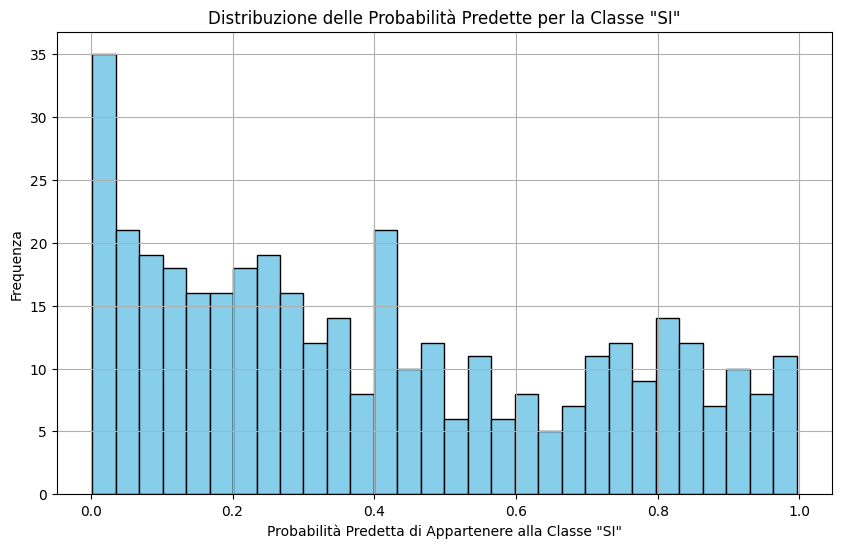

In [307]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

Iterazione Metodo Brute Force per trovare i migliori pesi da dare al nostro modello per massimizzare la ROC Curve

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


In [330]:

def objective(trial):
    w_catboost = trial.suggest_float("w_catboost", 0.0, 0.5)
    w_xgboost = trial.suggest_float("w_xgboost", 0.0, 0.5)
    w_lgbm = trial.suggest_float("w_lgbm", 0.0, 1 - w_xgboost - w_catboost)

    weights = [w_catboost, w_xgboost, w_lgbm]


    catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
    xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
    lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

    ensemble_predictions = (weights[0] * catboost_predictions) + (weights[1] * xgb_predictions) + (
        weights[2] * lgbm_predictions
    )

    ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)

    return ensemble_roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_w_catboost = study.best_params["w_catboost"]
best_w_xgboost = study.best_params["w_xgboost"]
best_w_lgbm = study.best_params["w_lgbm"]

best_weights = [best_w_catboost, best_w_xgboost, best_w_lgbm]
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]
best_ensemble_predictions = (best_weights[0] * catboost_predictions) + (best_weights[1] * xgb_predictions) + (best_weights[2] * lgbm_predictions)

best_ensemble_roc_auc = roc_auc_score(y_test, best_ensemble_predictions)

print("Best Weights:", best_weights)
print("Best Ensemble ROC AUC Score:", best_ensemble_roc_auc)



[I 2024-04-19 14:11:12,313] A new study created in memory with name: no-name-7c301aed-7916-4ce2-b587-f455adff5dad
[I 2024-04-19 14:11:13,551] Trial 0 finished with value: 0.9987055521991386 and parameters: {'w_catboost': 0.43031234146837655, 'w_xgboost': 0.21889743173181309, 'w_lgbm': 0.09784503280930534}. Best is trial 0 with value: 0.9987055521991386.
[I 2024-04-19 14:11:14,654] Trial 1 finished with value: 0.9991378875318374 and parameters: {'w_catboost': 0.15846127147209194, 'w_xgboost': 0.2826579599080744, 'w_lgbm': 0.26164837428662835}. Best is trial 1 with value: 0.9991378875318374.
[I 2024-04-19 14:11:15,753] Trial 2 finished with value: 0.998755314391927 and parameters: {'w_catboost': 0.4638015585283321, 'w_xgboost': 0.2626356054990283, 'w_lgbm': 0.12273014685730466}. Best is trial 1 with value: 0.9991378875318374.
[I 2024-04-19 14:11:17,059] Trial 3 finished with value: 0.9989102079779308 and parameters: {'w_catboost': 0.044383761781354836, 'w_xgboost': 0.3111892306949743, 'w

Best Weights: [0.3642352679633203, 0.05587351998074081, 0.4598174416722785]
Best Ensemble ROC AUC Score: 0.9994393693237809


In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)
best_weights = {
    "w_lgbm": 0.36,
    "w_catboost": 0.59,
    "w_xgboost": 0.05,
}


catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

# Calculate the weighted ensemble prediction
ensemble_predictions = (
    best_weights["w_lgbm"] * lgbm_predictions +
    best_weights["w_catboost"] * catboost_predictions +
    best_weights["w_xgboost"] * xgb_predictions 
)


In [374]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': ensemble_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

       y_test  y_pred_proba
186         1      0.996132
4927        1      0.995300
185         1      0.993118
847         1      0.992822
19464       1      0.990739
...       ...           ...
13581       0      0.000365
29844       0      0.000364
67344       0      0.000364
30688       0      0.000364
62702       0      0.000364

[10000 rows x 2 columns]


In [375]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 379
Numero di 'SI: nel nostro test set 380


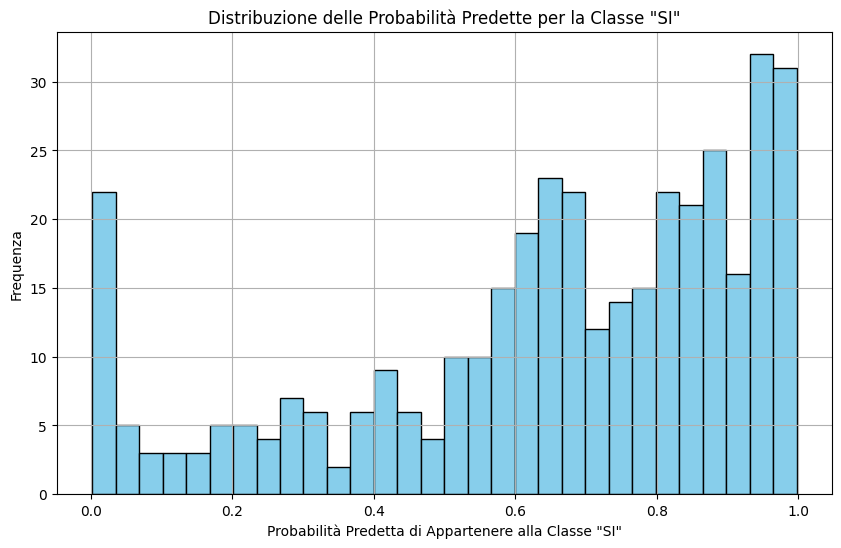

In [373]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

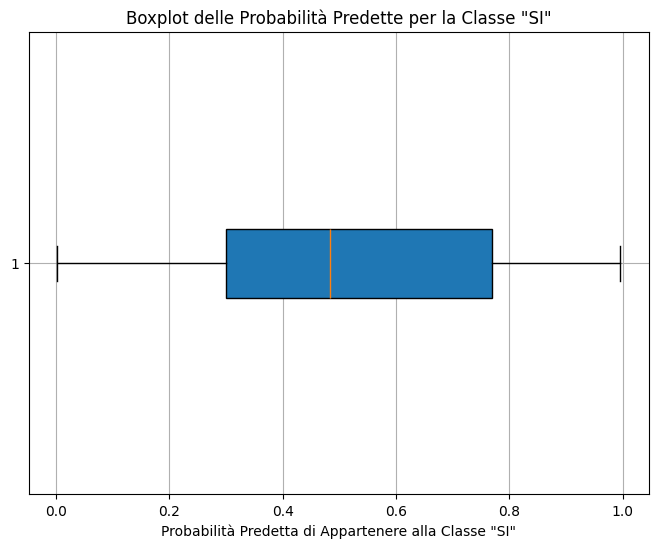

In [376]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()